<a href="https://colab.research.google.com/github/manola1109/Project---Emergency-vs-Non-Emergency-Vehicle-Sound-Classification/blob/main/Emergency_and_Non_emergency_audio_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Overview

By the end of this notebook, you will understand how to-

* Work with the audio data
* Represent an audio data - Time Domain and Spectrogram
* Build a deep learning model while working with audio data

<br>

# Understanding the Problem Statement

According to the National Crime Records Bureau, nearly 24,012 people die each day due to a delay in getting medical assistance. Many accident victims wait for help at the site, and a delay costs them their lives. The reasons could range from ambulances stuck in traffic to the fire brigade not being able to reach the site on time due to traffic jams.

The solution to the above problem is to create a system that automatically detects the emergency vehicle prior to reaching the traffic signals and change the traffic signals accordingly.

<br>

# Dataset

Download the dataset from [here](https://drive.google.com/file/d/1VBI_X6GyYvf8j3T70-_hVDyhR_sUzeCr/view?usp=sharing)

<br>

## Import Libraries

Let us first import the libraries into our environment

* **Librosa** is an open source library in Python that is used for audio and music analyis

* **Scipy** is a python library for scientific & technical computing. It contains modules for signal processing, image processing, and linear algebera

In [3]:
!pip install --upgrade --force-reinstall librosa

  Using cached librosa-0.11.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached numba-0.61.2-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.8 kB)
  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.15.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached decorator-5.2.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached soundfile-0.13.1-py2.py3-none-manylinux_2_28_x86_64.whl.metadata (16 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached soxr-0.5.0.post1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached typing_extensions-4.14.0-py3-none-any.whl.met

In [1]:
# For audio processing
import librosa
import scipy

In [2]:
# For playing audio
import IPython.display as ipd

# For array processing
import numpy as np

# For visualization
import matplotlib.pyplot as plt

# Load Audio Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# extract data
!unzip '//content/drive/MyDrive/audio.zip' -d ./audio_extracted/

# List the contents of the extraction directory to verify the files exist
!ls ./audio_extracted/audio/

Archive:  //content/drive/MyDrive/audio.zip
replace ./audio_extracted/non emergency.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
ls: cannot access './audio_extracted/audio/': No such file or directory


In [5]:
# import emergency vehicle data
path='/content/emergency.wav'
emergency,sample_rate = librosa.load(path, sr = 16000)

# import non-emergency vehicle data
path='/content/non emergency.wav'
non_emergency,sample_rate = librosa.load(path, sr =16000)

We have used the sampling rate (sr) of 16000 to read the above audio data. An audio wave of 2 seconds with a sampling rate of 16,000 will have 32,000 samples.

__Find the duration of the audio clips__

In [7]:
import librosa

duration1 = librosa.get_duration(y=emergency, sr=16000)
duration2 = librosa.get_duration(y=non_emergency, sr=16000)

print("Duration of an emergency and Non Emergency (in min):",duration1/60,duration2/60)

Duration of an emergency and Non Emergency (in min): 22.920290625 27.160834375


## Preparing Data

Let us break the audio into chunks of 2 seconds. So, let us define the function for the same task

In [8]:
def prepare_data(audio_data, num_of_samples=32000, sr=16000):

  data=[]
  for offset in range(0, len(audio_data), sr):
    start = offset
    end   = offset + num_of_samples
    chunk = audio_data[start:end]

    if(len(chunk)==32000):
      data.append(chunk)

  return data

Call the above function

In [9]:
# prepare audio chunks
emergency = prepare_data(emergency)
non_emergency = prepare_data(non_emergency)

In [10]:
print("No. of Chunks of Emergency and Non Emergency:",len(emergency),len(non_emergency))

No. of Chunks of Emergency and Non Emergency: 1374 1628


Lets listen to some of the clips

In [11]:
ipd.Audio(emergency[136],rate=16000)

In [12]:
ipd.Audio(non_emergency[10],rate=16000)

## Visualization of Audio Data

Let's visualize the audio wave in time domain

Text(0, 0.5, 'Amplitude')

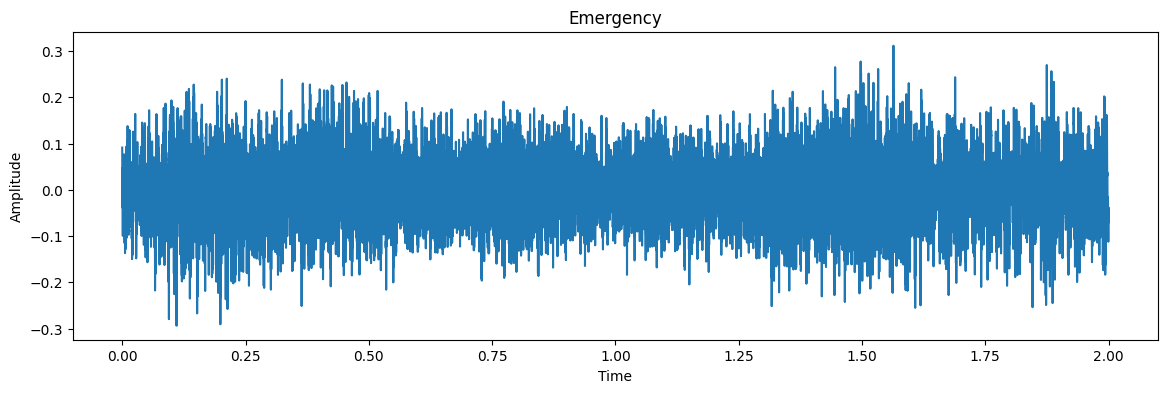

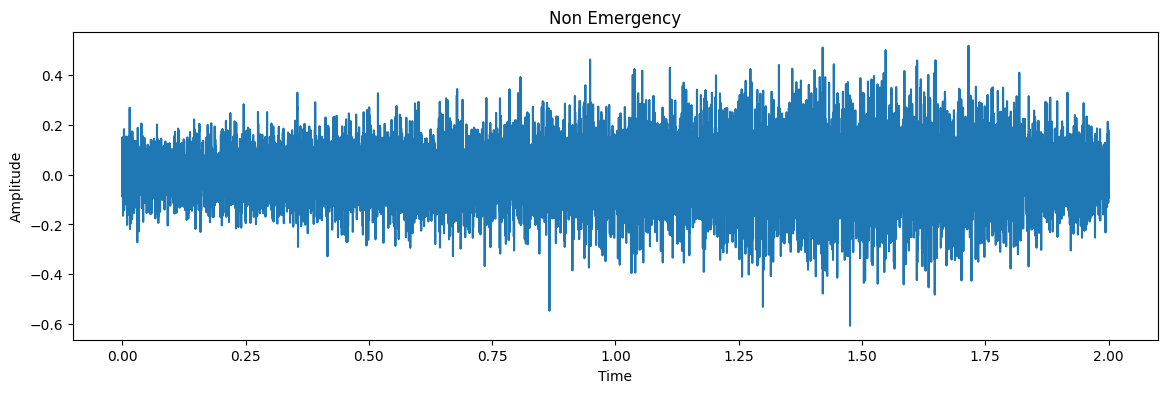

In [13]:
plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),emergency[103])
plt.title('Emergency')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),non_emergency[102])
plt.title('Non Emergency')
plt.xlabel('Time')
plt.ylabel('Amplitude')

__Combine Emergecy and Non Emergency chunks__

In [14]:
audio = np.concatenate([emergency,non_emergency])

In [15]:
# assign labels
labels1 = np.zeros(len(emergency))
labels2 = np.ones(len(non_emergency))

# concatenate labels
labels = np.concatenate([labels1,labels2])

Take a glance at the shape of the combined data.

In [16]:
print(audio.shape)

(3002, 32000)


**Split into train and validation set**

Next, we will train the model on 90% of the data and validate on the remaining 10%:

In [17]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(audio),np.array(labels),
                                            stratify=labels,test_size = 0.1,
                                            random_state=777,shuffle=True)

In [18]:
x_tr.shape, x_val.shape

((2701, 32000), (301, 32000))

The input must be 3 dimensional array - (no. of examples, timesteps, features)

So, lets reshape our input array according to the required shape

In [19]:
x_tr_features  = x_tr.reshape(len(x_tr),-1,1)
x_val_features = x_val.reshape(len(x_val),-1,1)

print("Reshaped Array Size",x_tr_features.shape)

Reshaped Array Size (2701, 32000, 1)


## Model Architecture

Let's define the model architecture using conv1D layers  and the time domain features.

In [22]:
from keras.layers import Input, Conv1D, Dropout, MaxPooling1D, GlobalMaxPool1D, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint

# CNN based deep learning model architecture
def conv_model(x_tr):

  inputs = Input(shape=(x_tr.shape[1],x_tr.shape[2]))

  #First Conv1D layer
  conv = Conv1D(8, 13, padding='same', activation='relu')(inputs)
  conv = Dropout(0.3)(conv)
  conv = MaxPooling1D(2)(conv)

  #Second Conv1D layer
  conv = Conv1D(16, 11, padding='same', activation='relu')(conv)
  conv = Dropout(0.3)(conv)
  conv = MaxPooling1D(2)(conv)

  # Global MaxPooling 1D
  conv = GlobalMaxPool1D()(conv)

  #Dense Layer
  conv = Dense(16, activation='relu')(conv)
  outputs = Dense(1,activation='sigmoid')(conv)

  model = Model(inputs, outputs)

  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
  # Changed the filepath extension from .hdf5 to .keras as required by recent Keras versions
  model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

  return model, model_checkpoint

__Call the model__

In [23]:
model, model_checkpoint = conv_model(x_tr_features)

Understand the shape and parameters at each layer

In [24]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32000, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 32000, 8)       │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32000, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 16000, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 16000, 16)      │         1,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16000, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 8000, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 16)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,825 (7.13 KB)

 Trainable params: 1,825 (7.13 KB)

 Non-trainable params: 0 (0.00 B)

Lets train the model for 10 epochs:

In [25]:
# model training
history = model.fit(x_tr_features, y_tr ,epochs=10,
                    callbacks=[model_checkpoint], batch_size=32,
                    validation_data=(x_val_features,y_val))

Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - acc: 0.5695 - loss: 0.6800
Epoch 1: val_loss improved from inf to 0.63646, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - acc: 0.5702 - loss: 0.6797 - val_acc: 0.8106 - val_loss: 0.6365
Epoch 2/10
81/85 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.7752 - loss: 0.5562
Epoch 2: val_loss improved from 0.63646 to 0.50546, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.7769 - loss: 0.5533 - val_acc: 0.8339 - val_loss: 0.5055
Epoch 3/10
81/85 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.8571 - loss: 0.3970
Epoch 3: val_loss improved from 0.50546 to 0.41449, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.8577 - loss: 0.3958 - val_acc: 0.8771 - val_loss: 0.4145
Epoch 4/10
81/85 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.8762 - loss: 0.3218
Epoch 4: val_loss improved from 0.41449 to 0.38305, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━

In [27]:
# load the best model weights
model.load_weights('best_model.keras')

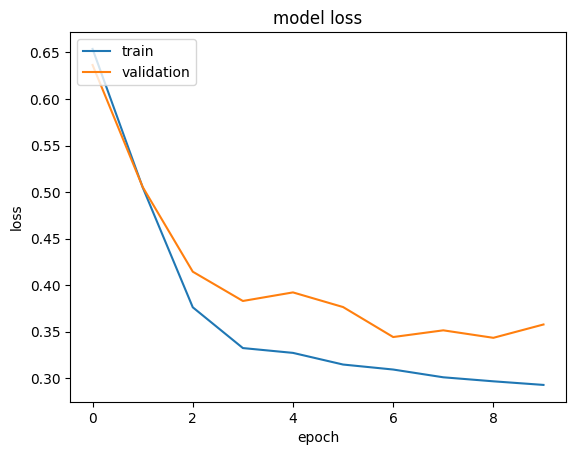

In [28]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Evaluate the model on hold out set

In [29]:
# check model's performance on the validation set
_, acc = model.evaluate(x_val_features,y_val)
print("Validation Accuracy:",acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8827 - loss: 0.3373 
Validation Accuracy: 0.8737541437149048


**Inference**

Let us make predictions on the hold out set

In [30]:
# input audio

ind=35
test_audio = x_val[ind]
ipd.Audio(test_audio,rate=16000)

In [31]:
# classification
feature = x_val_features[ind]
prob = model.predict(feature.reshape(1,-1,1))
if (prob[0][0] < 0.5):
  pred='emergency'
else:
  pred='non emergency'

print("Prediction:",pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
Prediction: emergency


<br>

Let's define the model architecture using LSTM layers and the time domain features.

In [32]:
# reshape chunks
x_tr_features  = x_tr.reshape(len(x_tr),-1,160)
x_val_features = x_val.reshape(len(x_val),-1,160)

print("Reshaped Array Size",x_tr_features.shape)

Reshaped Array Size (2701, 200, 160)


In [33]:
from keras.layers import LSTM

# LSTM based deep learning model architecture
def lstm_model(x_tr):

  inputs = Input(shape=(x_tr.shape[1],x_tr.shape[2]))

  #lstm
  x = LSTM(128)(inputs)
  x = Dropout(0.3)(x)

  #dense
  x= Dense(64,activation='relu')(x)
  x= Dense(1,activation='sigmoid')(x)

  model = Model(inputs, x)

  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

  return model

In [34]:
model = lstm_model(x_tr_features)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 200, 160)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       147,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,289 (610.50 KB)

 Trainable params: 156,289 (610.50 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [37]:
history=model.fit(x_tr_features, y_tr, epochs=10,
                  callbacks=[mc], batch_size=32,
                  validation_data=(x_val_features,y_val))

Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.5599 - loss: 0.6799
Epoch 1: val_loss improved from inf to 0.62081, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - acc: 0.5603 - loss: 0.6797 - val_acc: 0.6844 - val_loss: 0.6208
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.7169 - loss: 0.5588
Epoch 2: val_loss improved from 0.62081 to 0.54618, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - acc: 0.7169 - loss: 0.5588 - val_acc: 0.6944 - val_loss: 0.5462
Epoch 3/10
83/85 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.6824 - loss: 0.5902
Epoch 3: val_loss did not improve from 0.54618
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.6812 - loss: 0.5918 - val_acc: 0.6113 - val_loss: 0.6652
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.6536 - loss: 0.6201
Epoch 4: val_loss did not improve from 0.54618
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 0.6534 - loss: 0.6203 - val_acc: 0.6146 - val_loss: 0.6

In [39]:
# load best model weights
model.load_weights('best_model.keras')

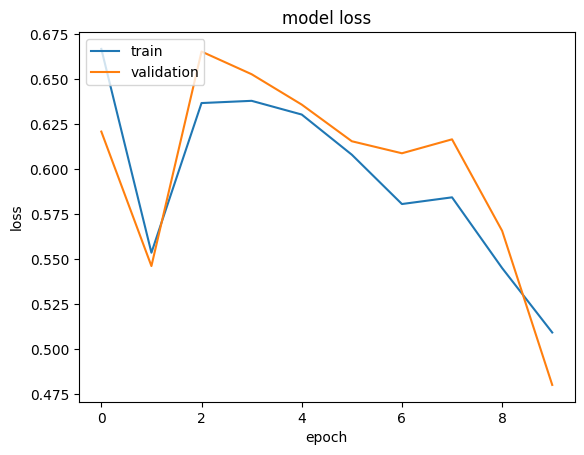

In [40]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [41]:
_,acc = model.evaluate(x_val_features,y_val)
print("Accuracy:",acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.7300 - loss: 0.4976
Accuracy: 0.7441860437393188


## Spectrogram Features

Let us define a function that computes the spectrogram. Before that, we need to understand how the spectrogram is computed.

Spectrogram accepts the raw audio wave and then breaks it into chunks or windows and then applies FFT on each window to compute the frequencies.

Coming to the parameters for computing spectrogram:

* nperseg = Size of the window i.e. number of samples in each chunk
* noverlap= Number of overlapping samples between each window

In [42]:
def log_specgram(audio, sample_rate, eps=1e-10):
    nperseg  = 320
    noverlap = 160

    freqs, times, spec = scipy.signal.spectrogram(audio,fs=sample_rate, nperseg=nperseg,noverlap=noverlap)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Define a function for representing spectrogram:

In [43]:
def plot(spectrogram,label):
  fig = plt.figure(figsize=(14, 8))
  ax = fig.add_subplot(211)
  ax.imshow(spectrogram.T, aspect='auto', extent=[times.min(), times.max(), freqs.min(), freqs.max()])
  ax.set_title('Spectrogram of '+label)
  ax.set_ylabel('Freqs in Hz')
  ax.set_xlabel('Seconds')

Compute the spectrogram:

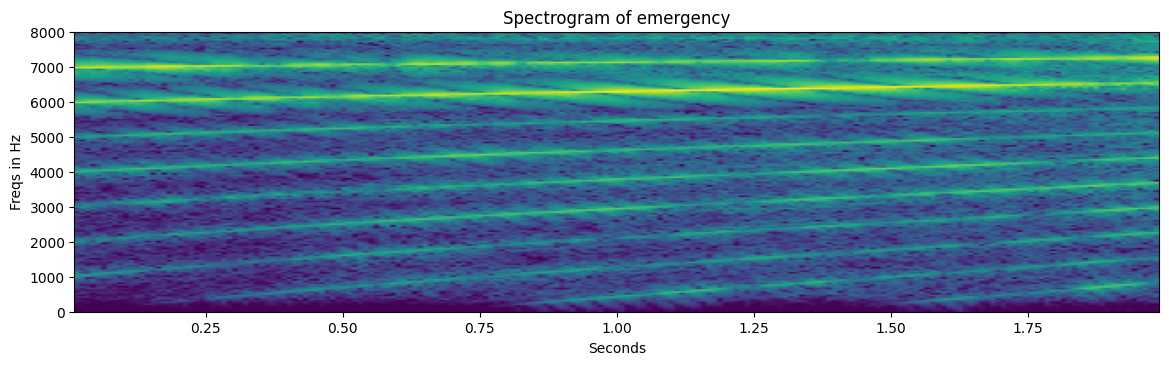

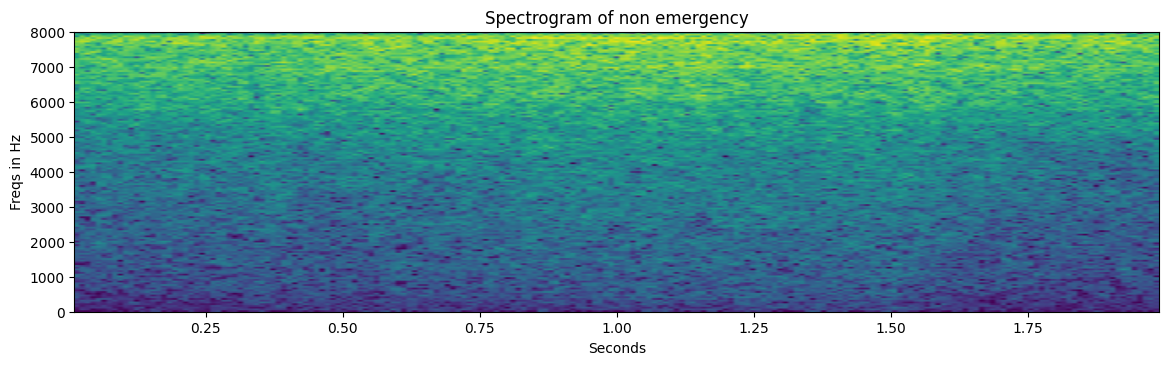

In [44]:
freqs, times, spectrogram = log_specgram(emergency[300], sample_rate)
plot(spectrogram,"emergency")

freqs, times, spectrogram = log_specgram(non_emergency[300], sample_rate)
plot(spectrogram,"non emergency")

In [45]:
spectrogram.shape

(199, 161)

__Extract the spectrogram features__

In [46]:
def extract_spectrogram_features(x_tr):
  features=[]
  for i in x_tr:
    _, _, spectrogram = log_specgram(i, sample_rate)

    mean = np.mean(spectrogram, axis=0)
    std = np.std(spectrogram, axis=0)
    spectrogram = (spectrogram - mean) / std

    features.append(spectrogram)

  return np.array(features)

In [47]:
x_tr_features  = extract_spectrogram_features(x_tr)
x_val_features = extract_spectrogram_features(x_val)

__Call the LSTM Model__

In [48]:
model_2 = lstm_model(x_tr_features)

In [50]:
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

Understand the no. of parameters and shape of each layer:

In [51]:
model_2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 199, 161)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       148,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,801 (612.50 KB)

 Trainable params: 156,801 (612.50 KB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [52]:
history=model_2.fit(x_tr_features, y_tr,
                    epochs=10, callbacks=[mc], batch_size=32,
                    validation_data=(x_val_features,y_val))

Epoch 1/10
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - acc: 0.5733 - loss: 0.6810
Epoch 1: val_loss improved from inf to 0.57550, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - acc: 0.5746 - loss: 0.6802 - val_acc: 0.7276 - val_loss: 0.5755
Epoch 2/10
81/85 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.8235 - loss: 0.4412
Epoch 2: val_loss improved from 0.57550 to 0.38147, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.8246 - loss: 0.4388 - val_acc: 0.8239 - val_loss: 0.3815
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.8430 - loss: 0.3671
Epoch 3: val_loss improved from 0.38147 to 0.28970, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.8432 - loss: 0.3668 - val_acc: 0.8870 - val_loss: 0.2897
Epoch 4/10
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.9115 - loss: 0.2515
Epoch 4: val_loss improved from 0.28970 to 0.22575, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━

Load the weights of the best model:

In [55]:
mc = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

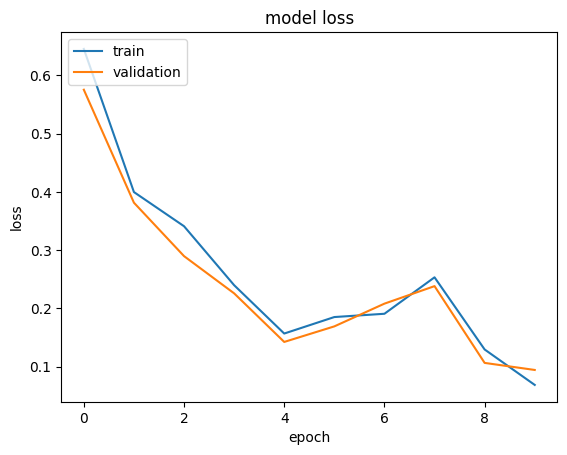

In [56]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Evaluating the performance of the model on validation set:

In [57]:
_,acc = model_2.evaluate(x_val_features,y_val)
print("Accuracy:",acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.9735 - loss: 0.0992
Accuracy: 0.970099687576294


<br>

Lets train the CNN based model on the same spectrogram features.


In [58]:
model_3, mc = conv_model(x_tr_features)

Understand the input and output shape of each layer:

In [59]:
model_3.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 199, 161)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 199, 8)         │        16,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 199, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 99, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 99, 16)         │         1,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 99, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 49, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 16)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,465 (72.13 KB)

 Trainable params: 18,465 (72.13 KB)

 Non-trainable params: 0 (0.00 B)

Training the model:

In [60]:
history=model_3.fit(x_tr_features, y_tr,
                    epochs=10, callbacks=[mc], batch_size=32,
                    validation_data=(x_val_features,y_val))

Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - acc: 0.5947 - loss: 0.7468
Epoch 1: val_loss improved from inf to 0.52953, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - acc: 0.5955 - loss: 0.7454 - val_acc: 0.7076 - val_loss: 0.5295
Epoch 2/10
83/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8042 - loss: 0.4127
Epoch 2: val_loss improved from 0.52953 to 0.31701, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - acc: 0.8052 - loss: 0.4110 - val_acc: 0.9203 - val_loss: 0.3170
Epoch 3/10
73/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8803 - loss: 0.2926
Epoch 3: val_loss improved from 0.31701 to 0.25380, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.8831 - loss: 0.2869 - val_acc: 0.9302 - val_loss: 0.2538
Epoch 4/10
76/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9068 - loss: 0.2255
Epoch 4: val_loss did not improve from 0.25380
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.9080 - loss: 0.2235 -

Load the best saved model

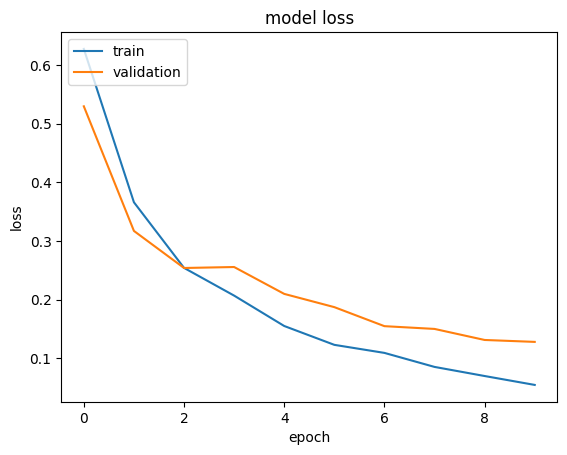

In [61]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Evaluating the performance of the model:

In [63]:
model_3.load_weights('best_model.keras')

In [64]:
# model's performance on the validation set
_,acc = model_3.evaluate(x_val_features,y_val)
print("Accuracy:",acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9433 - loss: 0.1242 
Accuracy: 0.9368770718574524


### What else to try?

* Different model architectures
* Use Frequency domain features
* Change input sequence length
* more...